In [34]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def split_xy(df):
    return df.iloc[:, :-1], df.iloc[:, -1]

train_df = pd.read_parquet('C:/Users/user/Desktop/bj/Bbeojung.kr/Data/final_dataset/train_1000.parquet')
test_df = pd.read_parquet('C:/Users/user/Desktop/bj/Bbeojung.kr/Data/final_dataset/test_1000.parquet')
x_train, y_train = split_xy(train_df)
x_test, y_test = split_xy(test_df)    

In [36]:
lgbm = LGBMRegressor()
lgbm.fit(x_train, y_train, eval_metric='mae')
y_pred = lgbm.predict(x_test)

MAE =  mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_pred)

print(f'MAE : {MAE}', f'MSE : {MSE}', f'RMSE : {RMSE}', f'R2 : {R2}', sep='\n')

MAE : 1.0111389684484722
MSE : 5.02314107779125
RMSE : 2.241236506438187
R2 : 0.9087367204414472


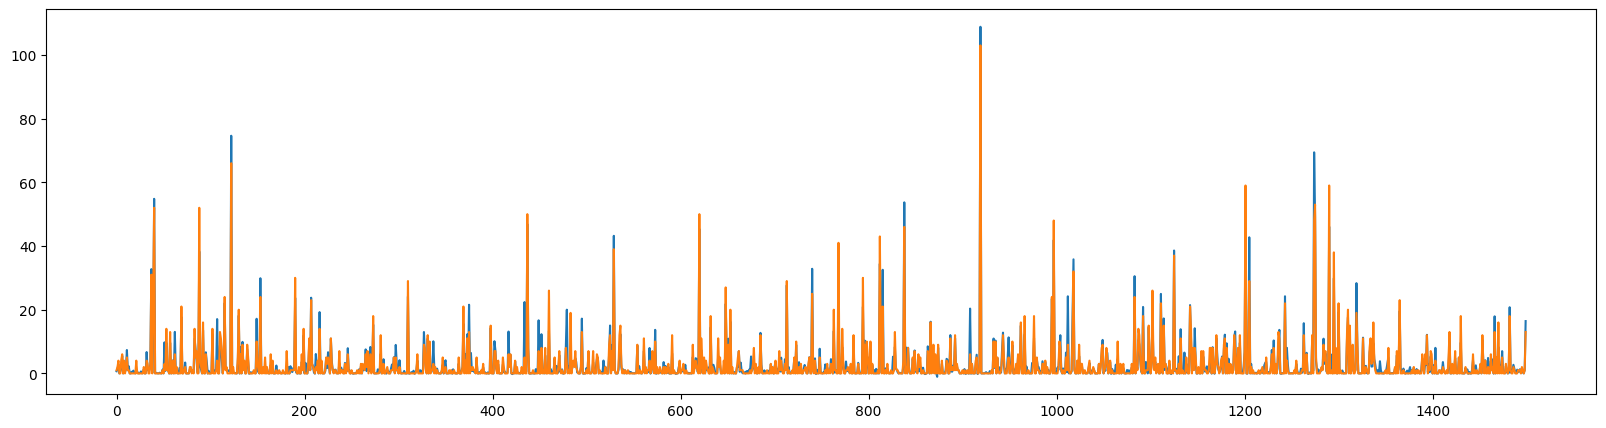

In [44]:
plt.figure(figsize=(20,5))
plt.plot(y_pred.tolist()[:1500])
plt.plot(y_test.tolist()[:1500])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

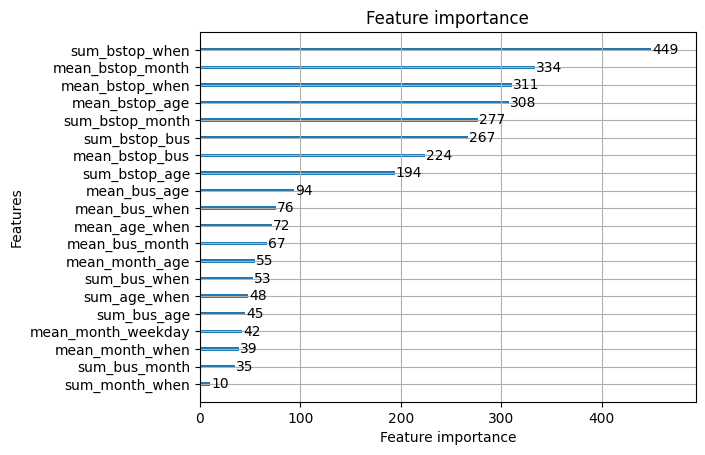

In [26]:
plot_importance(lgbm)